In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
from tensorboardX import SummaryWriter

torch.manual_seed(1)

In [2]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# define corpus
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

In [4]:
# step1. creating vocabulary

# tokenize sentences
def tokenize_corpus(corpus):
    tokens = [sentence.split() for sentence in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

print("tokenized corpus:", tokenized_corpus)

# word->idx, idx->word
word2idx = {}
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in word2idx:
            word2idx[token] = len(word2idx)

idx2word = {v: k for k, v in word2idx.items()}

print("word2idx:", word2idx)
print("\nidx2word:", idx2word)

word_vocab_size = len(word2idx)

print("\nword_vocab_size:", word_vocab_size)

tokenized corpus: [['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['warsaw', 'is', 'poland', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital']]
word2idx: {'he': 0, 'is': 1, 'a': 2, 'king': 3, 'she': 4, 'queen': 5, 'man': 6, 'woman': 7, 'warsaw': 8, 'poland': 9, 'capital': 10, 'berlin': 11, 'germany': 12, 'paris': 13, 'france': 14}

idx2word: {0: 'he', 1: 'is', 2: 'a', 3: 'king', 4: 'she', 5: 'queen', 6: 'man', 7: 'woman', 8: 'warsaw', 9: 'poland', 10: 'capital', 11: 'berlin', 12: 'germany', 13: 'paris', 14: 'france'}

word_vocab_size: 15


In [5]:
# step 2. Generate pairs (center word - context word)
window_size = 2
idx_pairs = []

# for each sentence
for sentence in tokenized_corpus:
    word_idxs = [word2idx[word] for word in sentence]
    for center_word_pos in range(len(word_idxs)):
        for w in range(-window_size, window_size+1):
            context_word_pos = center_word_pos + w
            
            if context_word_pos < 0 or context_word_pos >= len(word_idxs) or center_word_pos == context_word_pos:
                continue
            idx_pairs.append((word_idxs[center_word_pos], word_idxs[context_word_pos]))
            
            
idx_pairs = np.array(idx_pairs)
print(idx_pairs.shape)

(70, 2)


## Defining goal
@ We want to predict context, given center word and soma parametrization.

@ We are making P(context | center) close to 0 for all non-existing (context, center) pairs.

In [6]:
# input layer: just the center word encoded in one-hot manner.
def get_one_hot(word_idx, word_vocab_size):
    x = torch.zeros(word_vocab_size).float()
    x[word_idx] = 1.0
    return x

In [12]:
embedding_dim = 5
num_epochs = 500
lr = 0.03

In [13]:
class W2Vnet(nn.Module):
    def __init__(self, embedding_dim, word_vocab_size):
        super(W2Vnet, self).__init__()
        
        self.net1 = nn.Linear(word_vocab_size, embedding_dim, bias=False)
        self.net2 = nn.Linear(embedding_dim, word_vocab_size, bias=False)
        
    def forward(self, x):
        out1 = self.net1(x)
        out2 = self.net2(out1)
        out = F.log_softmax(out2, dim=0).view(1, -1)
        return out

In [14]:
model = W2Vnet(embedding_dim, word_vocab_size).to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=lr)

W2Vnet(
  (net1): Linear(in_features=15, out_features=5, bias=False)
  (net2): Linear(in_features=5, out_features=15, bias=False)
)


In [15]:
for epoch in range(num_epochs):
    loss_val = 0
    for center, context in idx_pairs:    
        input = get_one_hot(center, word_vocab_size).to(device).float()
        target = torch.from_numpy(np.array([context])).to(device).long()
        
        output = model(input)
    
        loss = F.nll_loss(output, target)
        loss_val += loss.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print("[%d/%d] loss:%.3f" % (epoch+1, num_epochs, loss_val / float(len(idx_pairs))))

[1/500] loss:2.710
[11/500] loss:2.437
[21/500] loss:1.993
[31/500] loss:1.870
[41/500] loss:1.814
[51/500] loss:1.779
[61/500] loss:1.753
[71/500] loss:1.732
[81/500] loss:1.717
[91/500] loss:1.705
[101/500] loss:1.696
[111/500] loss:1.688
[121/500] loss:1.682
[131/500] loss:1.678
[141/500] loss:1.674
[151/500] loss:1.672
[161/500] loss:1.670
[171/500] loss:1.669
[181/500] loss:1.668
[191/500] loss:1.668
[201/500] loss:1.667
[211/500] loss:1.667
[221/500] loss:1.667
[231/500] loss:1.666
[241/500] loss:1.666
[251/500] loss:1.666
[261/500] loss:1.666
[271/500] loss:1.666
[281/500] loss:1.666
[291/500] loss:1.666
[301/500] loss:1.666
[311/500] loss:1.666
[321/500] loss:1.666
[331/500] loss:1.666
[341/500] loss:1.666
[351/500] loss:1.666
[361/500] loss:1.666
[371/500] loss:1.666
[381/500] loss:1.666
[391/500] loss:1.666
[401/500] loss:1.666
[411/500] loss:1.666
[421/500] loss:1.666
[431/500] loss:1.667
[441/500] loss:1.667
[451/500] loss:1.667
[461/500] loss:1.667
[471/500] loss:1.667
[48

In [16]:
print("After training:")

import numpy as np

model.eval()

W1 = np.array(list(model.net1.parameters()))[0].detach().cpu().numpy()
W2 = np.array(list(model.net2.parameters()))[0].detach().cpu().numpy()
print("W1:", W1)
print("W1 shape:", W1.shape)
print("W2:", W2)
print("W2 shape:", W2.shape)

After training:
W1: [[ 0.3928717   0.3541354  -1.7281435   0.36305234  0.3059581   0.34199578
   0.38376528  0.37513843  1.7270766  -0.524272    1.4157332   0.55498534
  -1.7750574   0.99058914 -1.2203745 ]
 [-2.30546     0.6440879  -0.5704936  -2.2079875  -2.3035276  -2.2088296
  -2.2037015  -2.207249   -1.1883634  -1.0973867  -1.1952554  -1.9348512
  -1.7500494  -1.7532874  -0.9134545 ]
 [-0.2855567  -1.1544695   1.4688495  -0.2474238  -0.2972224  -0.30873835
  -0.22912996 -0.24058919  1.5691415  -0.5259165   1.2277739   1.5843222
  -1.1354835   0.40437767 -0.15140185]
 [-0.27139515 -0.52757233 -0.29394612 -0.29204765 -0.3136087  -0.22913398
  -0.29299137 -0.2978228   1.4053267   2.3571827   0.5423706  -1.0966215
   0.8031084   1.5849426   2.8319416 ]
 [ 0.95908415  0.1024945   0.437641    0.93682426  0.93030864  0.92941225
   0.9836217   0.9565741   0.6477556   1.2725508  -0.71768785 -1.2365643
  -1.4067404  -1.9701883  -0.7664447 ]]
W1 shape: (5, 15)
W2: [[-1.6115879   1.3282703   

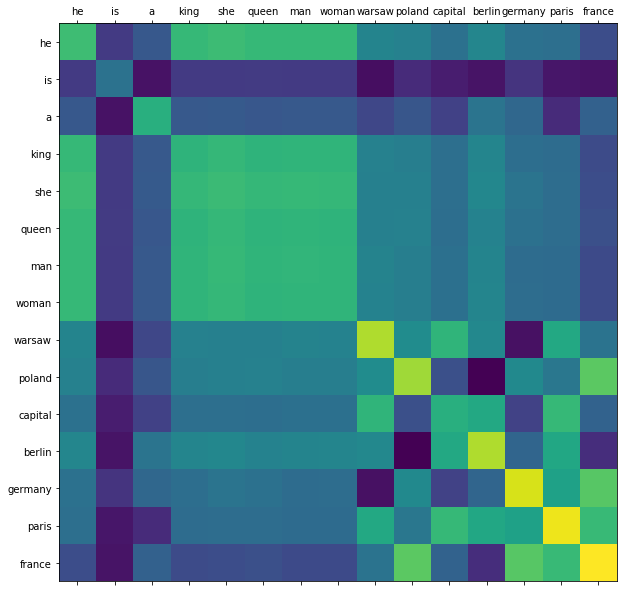

In [17]:
# If i choose W1
# plotting correlation matrix
# lighter color => more related

import matplotlib.pyplot as plt

W1_t = np.transpose(W1, (1, 0))

corr = np.matmul(W1_t, W1)
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)

groups = list(word2idx.keys())
x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups)

y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

plt.show()

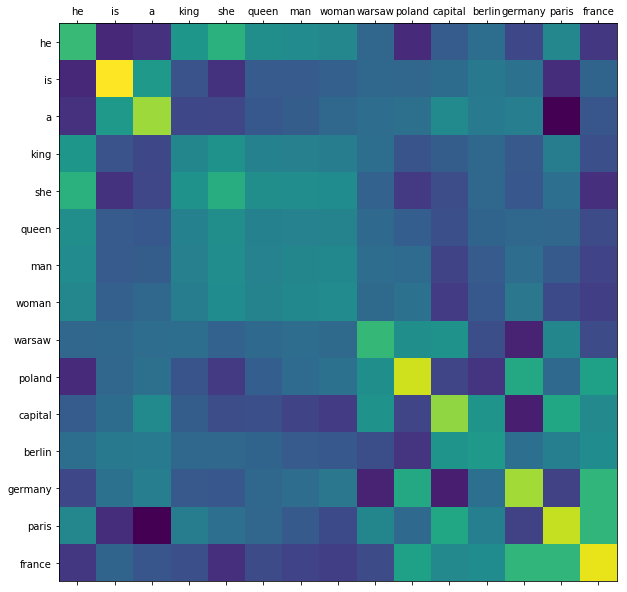

In [18]:
# If I choose W2
W2_t = np.transpose(W2, (1, 0))
corr = np.matmul(W2, W2_t)
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)

x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups)

y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

plt.show()

In [19]:
writer = SummaryWriter(".\\tensorboard")

print(W1.shape)
print(len(groups))
writer.add_embedding(W1_t, metadata=groups)
writer.close()

(5, 15)
15


### Result embedding graph using tensorboard

![](07_SG_tensorboard.PNG)